### Star Masking

Bright/Close stars produce artifacts and false detections in panstarrs. These need to be removed as they sometimes appear as galaxies to the machine learning model.

Remove them by looking at a number of bright stars in the APASS, TYCHO catalogues and getting the panstarrs detections. Seeing how large of a circle must be constructed around the star to remove faulty detections and replace those detections with the stars' information.

1) Get Stars from APASS, TYCHO.
2) Get associated PanSTARRS detections.
3) Get size of cirlce to remove bad detections.
4) Repeat for number of different stars at different magnitudes.

Need to write function to check if a list of points/coords are in a circle (area around the star).
Write a function to be able to call and rapidly test different 

- search location and get all detections
- get associated panstarrs detections for this area (maybe 1 query will do for whole area and just crop plot to image)
- function to get each image and plot relevant info (nearby sources, size of mask in px etc)
- image must be interactable i.e. can adjust size of diameter of mask with slider + have button for next image
    - maybe read these images in one at a time on each click of next button
- store store index index of plot and associated data i.e. mask size, magnitude etc in new dataframe
- save this dataframe

In [1]:
#for querying sources
import astroFuncs as af
#lets us use casjobs
af.mastcasjobs_init()

#for visualising images
import matplotlib.pyplot as plt
#coordinate stuff for plotting
from astropy import wcs
from astropy.visualization import PercentileInterval, AsinhStretch, SqrtStretch
from astropy.visualization.wcsaxes import WCSAxes
from astropy.coordinates import SkyCoord, search_around_sky
import astropy.units as u

#general use
import numpy as np
import pandas as pd

#interactive plots
from ipywidgets import interact
import ipywidgets as widgets
from matplotlib.patches import Circle
from matplotlib.widgets import Slider, Button

#other visualisation
import seaborn as sns

# #ignore warning when reading outdated wcs coords
# import warnings
# warnings.filterwarnings("ignore")

Enter Casjobs username: richardon
Enter Casjobs password: ········


In [2]:
#this is the area we will get sample stars from to mask
ra, dec = 20, 30
rad = 1

In [3]:
#this function searches the apass and tycho catalogues and cross-matches them
stars = af.search_bright_stars(ra, dec, rad)

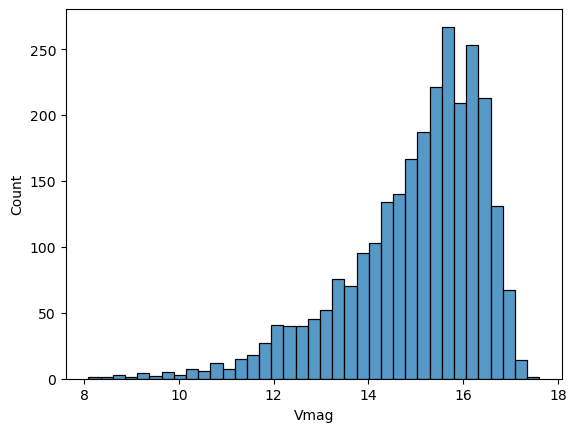

In [4]:
%matplotlib inline
#looking at the distribution of magnitudes
sns.histplot(stars.loc[:]['Vmag'])
plt.show()

In [5]:
#magnitude bins -> [10,12,14,16,18,20]

#over 8 under 10
bin_0 = stars.query("Vmag < 10")

#over 10 under 12
bin_1 = stars.query("Vmag > 10 & Vmag < 12")

#over 12 under 14
bin_2 = stars.query("Vmag > 12 & Vmag < 14")

#over 14 under 16
bin_3 = stars.query("Vmag > 14 & Vmag < 16")

#over 16 under 18
bin_4 = stars.query("Vmag > 16 & Vmag < 18")

#over 18
bin_5 = stars.query("Vmag > 18")

In [6]:
#gonna go with 10 samples from each bin
n_samples = 10

#get dataframe for each bin
frames = [bin_0[:n_samples], bin_1[:n_samples], bin_2[:n_samples], bin_3[:n_samples], bin_4[:n_samples], bin_5[:n_samples]]

#add them together
star_samples = pd.concat(frames).reset_index(drop=True)

In [7]:
#not enough samples for each magnitude so going to load some in manually
filepath = "/home/richard/Work/placement_project/CNGFPPR/files/custom_star_masking_files/"

under_2 = pd.read_csv(filepath+"hipp_tycho_search_under2mag.tsv",
                      delimiter="\t", header=48).drop([0,1]).reset_index(drop=True)
under_2 = under_2.astype({'Vmag':'float', 'RAICRS':'float','DEICRS':'float'})

between_2_4 = pd.read_csv(filepath+"hipp_tycho_search_between2_4mag.tsv",
                          delimiter="\t", header=48).drop([0,1]).reset_index(drop=True)
between_2_4 = between_2_4.astype({'Vmag':'float', 'RAICRS':'float','DEICRS':'float'})

between_4_6 = pd.read_csv(filepath+"hipp_tycho_search_between4_6mag.tsv",
                          delimiter="\t", header=48).drop([0,1]).reset_index(drop=True)
between_4_6 = between_4_6.astype({'Vmag':'float', 'RAICRS':'float','DEICRS':'float'})


between_6_8 = pd.read_csv(filepath+"hipp_tycho_search_between6_8mag.tsv",
                          delimiter="\t", header=48).drop([0,1]).reset_index(drop=True)
between_6_8 = between_6_8.astype({'Vmag':'float', 'RAICRS':'float','DEICRS':'float'})

In [8]:
supplemental_bin_0 = under_2.query("DEICRS > -20").sort_values(by="Vmag").reset_index(drop=True).iloc[[0,1,2,4,5,6,9,14,17,19]]

supplemental_bin_1 = between_2_4.query("DEICRS > -20").sort_values(by="Vmag").reset_index(drop=True).iloc[[0,2,3,5,6,10,12,13,15,17]]

supplemental_bin_2 = between_4_6.query("DEICRS > -20").sort_values(by="Vmag").reset_index(drop=True).iloc[[0,1,3,6,7,12,13,16,22,23]]

supplemental_bin_3 = between_6_8.query("DEICRS > -20").sort_values(by="Vmag").reset_index(drop=True).iloc[[0,2,6,8,11,12,20,21,26,32]]

In [9]:
supplemental_frames = [supplemental_bin_0, supplemental_bin_1, supplemental_bin_2, supplemental_bin_3]

#add them together
suplemental_star_samples = pd.concat(supplemental_frames).reset_index(drop=True)

In [10]:
# star_samples = star_samples[["AP_RA","AP_DEC","Vmag"]]
star_samples = star_samples.rename(mapper={"AP_RA":"ra", "AP_DEC":"dec"}, axis=1)

suplemental_star_samples = suplemental_star_samples[["RAICRS","DEICRS","Vmag"]]
suplemental_star_samples = suplemental_star_samples.rename(mapper={"RAICRS":"ra", "DEICRS":"dec"}, axis=1)


star_masking_df = pd.concat([star_samples, suplemental_star_samples]).reset_index(drop=True)

In [11]:
star_masking_df

,key_0,ra,dec,e_RAJ2000,e_DEJ2000,Field,nobs,mobs,B-V,e_B-V,...,pmRA,pmDE,BTmag,VTmag,HIP,TYC1,TYC2,TYC3,RA,Dec
0,265.0,19.825927,29.217798,0.302,0.159,20121431.0,6.0,64.0,1.458,0.279,...,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,19.825927,29.217798
1,506.0,19.491999,29.492596,0.219,0.450,20121431.0,10.0,95.0,0.460,0.244,...,40.0,-18.200001,9.666,9.290,<NA>,1753.0,625.0,1.0,19.491999,29.492596
2,570.0,19.717663,29.507802,0.089,0.298,20121431.0,13.0,109.0,0.441,0.246,...,-5.6,2.800000,10.427,9.979,<NA>,1754.0,1298.0,1.0,19.717663,29.507802
3,685.0,19.599073,29.583433,0.112,0.278,20121431.0,9.0,79.0,0.997,0.190,...,-15.9,4.600000,10.132,8.852,<NA>,1754.0,2326.0,1.0,19.599073,29.583433
4,778.0,19.668252,29.822978,0.112,0.343,20121431.0,8.0,74.0,0.304,0.125,...,-8.6,-21.900000,9.341,8.927,6128,1754.0,1659.0,1.0,19.668252,29.822978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,NaN,352.259246,16.012546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN
86,NaN,352.469596,35.014040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN
87,NaN,352.167392,39.619044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN
88,NaN,352.205582,72.229975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN


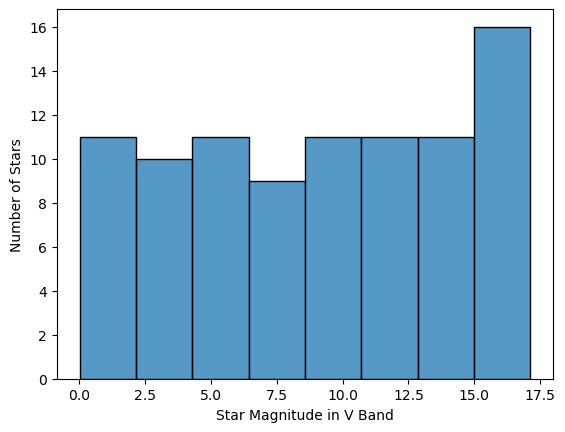

In [20]:
sns.histplot(star_masking_df.Vmag)
plt.xlabel("Star Magnitude in V Band")
plt.ylabel("Number of Stars")
plt.savefig("star_masking_histogram.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [13]:
#get table of images for each star in above datafram, the r filter is used

size=1400

image_table = af.getImageTable(list(star_masking_df.ra), list(star_masking_df.dec), size=size, filters="r")


In [14]:
image_table #looking at the table, the urls can be used to retrieve a fits image,

,projcell,subcell,ra,dec,filter,mjd,type,filename,shortname,badflag,url
0,1934,31,19.825927,29.217798,r,0.0,stack,/rings.v3.skycell/1934/031/rings.v3.skycell.1934.031.stk.r.unconv.fits,rings.v3.skycell.1934.031.stk.r.unconv.fits,0,https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?size=1400&format=fits&ra=19.825927&dec=29.217798&red=/rings.v3.skycell/1934/031/rings.v3.skycell.1934.031.stk.r.unconv.fits
1,1934,32,19.491999,29.492596,r,0.0,stack,/rings.v3.skycell/1934/032/rings.v3.skycell.1934.032.stk.r.unconv.fits,rings.v3.skycell.1934.032.stk.r.unconv.fits,0,https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?size=1400&format=fits&ra=19.491999&dec=29.492596&red=/rings.v3.skycell/1934/032/rings.v3.skycell.1934.032.stk.r.unconv.fits
2,1934,31,19.717663,29.507802,r,0.0,stack,/rings.v3.skycell/1934/031/rings.v3.skycell.1934.031.stk.r.unconv.fits,rings.v3.skycell.1934.031.stk.r.unconv.fits,0,https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?size=1400&format=fits&ra=19.717663&dec=29.507802&red=/rings.v3.skycell/1934/031/rings.v3.skycell.1934.031.stk.r.unconv.fits
3,1934,32,19.599073,29.583433,r,0.0,stack,/rings.v3.skycell/1934/032/rings.v3.skycell.1934.032.stk.r.unconv.fits,rings.v3.skycell.1934.032.stk.r.unconv.fits,0,https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?size=1400&format=fits&ra=19.599073&dec=29.583433&red=/rings.v3.skycell/1934/032/rings.v3.skycell.1934.032.stk.r.unconv.fits
4,1934,41,19.668252,29.822978,r,0.0,stack,/rings.v3.skycell/1934/041/rings.v3.skycell.1934.041.stk.r.unconv.fits,rings.v3.skycell.1934.041.stk.r.unconv.fits,0,https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?size=1400&format=fits&ra=19.668252&dec=29.822978&red=/rings.v3.skycell/1934/041/rings.v3.skycell.1934.041.stk.r.unconv.fits
...,...,...,...,...,...,...,...,...,...,...,...
85,1762,3,352.259246,16.012546,r,0.0,stack,/rings.v3.skycell/1762/003/rings.v3.skycell.1762.003.stk.r.unconv.fits,rings.v3.skycell.1762.003.stk.r.unconv.fits,0,https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?size=1400&format=fits&ra=352.25924647&dec=16.01254578&red=/rings.v3.skycell/1762/003/rings.v3.skycell.1762.003.stk.r.unconv.fits
86,2083,71,352.469596,35.014040,r,0.0,stack,/rings.v3.skycell/2083/071/rings.v3.skycell.2083.071.stk.r.unconv.fits,rings.v3.skycell.2083.071.stk.r.unconv.fits,0,https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?size=1400&format=fits&ra=352.46959647&dec=35.01403966&red=/rings.v3.skycell/2083/071/rings.v3.skycell.2083.071.stk.r.unconv.fits
87,2155,90,352.167392,39.619044,r,0.0,stack,/rings.v3.skycell/2155/090/rings.v3.skycell.2155.090.stk.r.unconv.fits,rings.v3.skycell.2155.090.stk.r.unconv.fits,0,https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?size=1400&format=fits&ra=352.16739208&dec=39.61904371&red=/rings.v3.skycell/2155/090/rings.v3.skycell.2155.090.stk.r.unconv.fits
88,2597,0,352.205582,72.229975,r,0.0,stack,/rings.v3.skycell/2597/000/rings.v3.skycell.2597.000.stk.r.unconv.fits,rings.v3.skycell.2597.000.stk.r.unconv.fits,0,https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?size=1400&format=fits&ra=352.20558236&dec=72.22997505&red=/rings.v3.skycell/2597/000/rings.v3.skycell.2597.000.stk.r.unconv.fits


In [23]:
#lets visually verify each of the chosen stars are stars
af.plot_cutouts(image_table.ra, image_table.dec, nrows=10, ncols=9, figsize=(25,65))

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fe83cf7c310> (for post_execute):


KeyboardInterrupt: 

In [15]:
def start_eval():
    %matplotlib ipympl
    """
    This function creates an interactive plot object with interactive sliders, one changes the radius of
    the selected mask, the other changes the percentile of the image displayed for alternative views.
    
    Selecting the "next image button" will plot the next fits image and the process can be repeated of 
    selecting an appropriately sized mask
    
    The radii of each selected mask is recorded into lists labelled ra_list, dec_list and mask_list respectively.
    The index of each item corresponds to the star_masking_df and image_table dataframes.
    """
    global fig, ax
    #create plot
    fig, ax = plt.subplots()
    #initialise counter
    global counter
    # counter = -1
    counter = 49
    #create interactive next button
    global next_button
    next_button_ax = fig.add_axes([0.91, 0.12, 0.088, 0.05]) #setting axes (where the button will lie)
    next_button = Button(next_button_ax, "Next Image") #making the button
    next_button.label.set_fontsize(6.9) # changing font size
    next_button.on_clicked(next_image) #on click this button will activate the next_image function
    
    global rad_slider #creating sliders in similar fashion
    rad_slider_ax = fig.add_axes([0.95,0.6,0.02,0.25])
    rad_slider = Slider(rad_slider_ax, "Radius", valmin=1, valmax=800, valinit=10, valstep=1, orientation="vertical")
    rad_slider.on_changed(update_rad)
    
    global interval_slider #same as above
    interval_slider_ax = fig.add_axes([0.95,0.25, 0.02,0.25])
    interval_slider = Slider(interval_slider_ax, "Show%", valmin=0, valmax=100, valinit=95, orientation="vertical")
    interval_slider.on_changed(update_transform)
    
    global ra_list, dec_list, mask_list #make the list to record masks
    
    ra_list = []
    dec_list = []
    mask_list = []
    
    next_image(0) #call next image to start the plotting, counter value is adjusted previously for this
    return

def next_image(val):
    """
    this function clears current plot and plots the next image.
    It also saves the value of the mask size
    """
    global counter
    
    if counter >= 50: #if not the first instance of calling next_image then save these values
        ra_list.append(star_masking_df.ra.iloc[counter])
        dec_list.append(star_masking_df.dec.iloc[counter])
        mask_list.append(rad_slider.val)
    
    #increase counter value, this is to move onto plotting the next iomage
    counter = counter+1
    
    #retireve url from the image table of index counter
    url = image_table.url.iloc[counter]
    
    global data
    #af.readFitsImage loads a fits image from a url into memory and returns the image data and header
    header, data = af.readFitsImage(url)
    w = wcs.WCS(header) #getting the world coordinate system from the header
    image = get_transformed_image(data) #transforming the image based on display interval and the selected transform
    
    circ_center_coords = SkyCoord(ra=image_table.ra[counter]*u.deg, #creating skycoord object of the star centre
                                  dec=image_table.dec[counter]*u.deg)
    
    circ_center_px = w.world_to_pixel(circ_center_coords) #getting px coords to plot circle patch from matplotlib
    global circ
    circ = Circle(circ_center_px, rad_slider.val, color='b', fill=False) #creating the circle patch
    
    global fig, ax
    ax.remove() #remove old ax with image
    ax = WCSAxes(fig, [0.1, 0.1, 0.8, 0.8], wcs=w) #initialise new ax with the new WCS
    fig.add_axes(ax) #add ax to figure
    
    global im
    im = ax.imshow(image, cmap="bone") #show the transformed image with cmap bone
    ax.add_patch(circ) #add the adjustable circ patch
    
    nearby_det_ra, nearby_det_dec = get_nearby_ps_dets(circ_center_coords) #using skycoord obj to get index of all detections nearby the star
    
    ax.plot(nearby_det_ra, nearby_det_dec, transform=ax.get_transform("fk5"), alpha=0.85, marker="o", mec="r", mfc="none", ls="") #plot the detections
    ax.plot(circ_center_px[0], circ_center_px[1], "bx") #plot the circle
    ax.set_xlim(0,size) #set image limits
    ax.set_ylim(0,size)
    ax.set_title(f"Counter: {counter}")
    return

def update_rad(val):
    """
    this function updates the radius of the circle patch from matplotlib to help visualise how large of an are around the star is being masked.
    val is necessary to enable the function to be called by the slider
    """
    circ.set_radius(rad_slider.val) #set new radius
    plt.draw() #redraw the circlle
    return

def get_transformed_image(data):
    """
    this function takes image data and applys a sqrtstretch and percentile interval transform based on the slider value in the plot
    the function returns the transformed image
    """
    transform = SqrtStretch() + PercentileInterval(interval_slider.val)
    image = transform(data)
    return image

def update_transform(val):
    """
    this function updates the transformed image inside of the figure
    """
    transform = SqrtStretch() + PercentileInterval(interval_slider.val)
    image = transform(data)
    #sets new image data here
    im.set_array(image)
    return


def get_nearby_ps_dets(center_coord, seplim=(4/60)):
    ra = center_coord.ra.deg
    dec = center_coord.dec.deg
    
    dets = af.quick_search_circ_region(ra,dec,seplim)
    
    ra_dets = dets.raMean
    dec_dets = dets.decMean
    
    return ra_dets, dec_dets

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


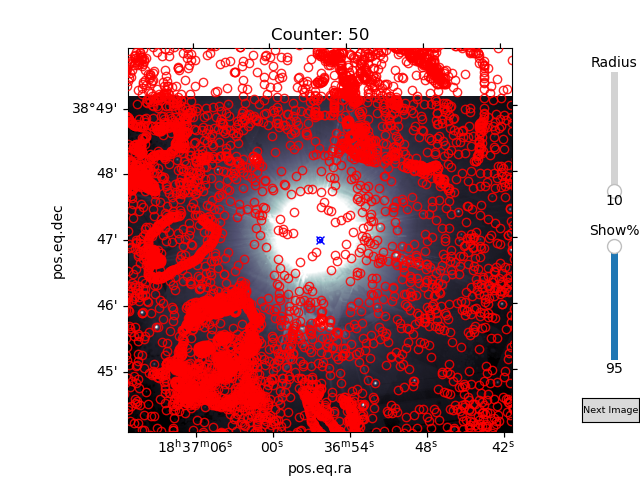

In [16]:
#starting the figure
start_eval()

In [21]:
#resetting to non-interactive plots
%matplotlib inline

In [22]:
len(mask_list)

2

In [23]:
#creating dataframe of results
det_info = {"ra":ra_list, "dec":dec_list, "mask_radius_px":mask_list}
masking_df = pd.DataFrame(data=det_info)

In [24]:
#looking
masking_df.head()

,ra,dec,mask_radius_px
0,279.234108,38.782993,351
1,79.172065,45.999029,457


In [32]:
#save as csv
masking_df["Vmag"] = star_masking_df.Vmag
masking_df.to_csv("star_masking_results.csv", index=False)

In [36]:
#loading one I prepared earlier
masking_res = pd.read_csv(filepath+"star_masking_results_27_june_2023.csv")


In [37]:
masking_res

,ra,dec,mask_radius_px,mask_radius_deg,Vmag
0,19.825927,29.217798,103,0.007153,8.432
1,19.491999,29.492596,23,0.001597,9.222
2,19.717663,29.507802,26,0.001806,9.944
3,19.599073,29.583433,33,0.002292,8.779
4,19.668252,29.822978,31,0.002153,8.906
...,...,...,...,...,...
85,352.259246,16.012546,58,0.004028,7.110
86,352.469596,35.014040,65,0.004514,7.530
87,352.167392,39.619044,32,0.002222,7.670
88,352.205582,72.229975,33,0.002292,7.740


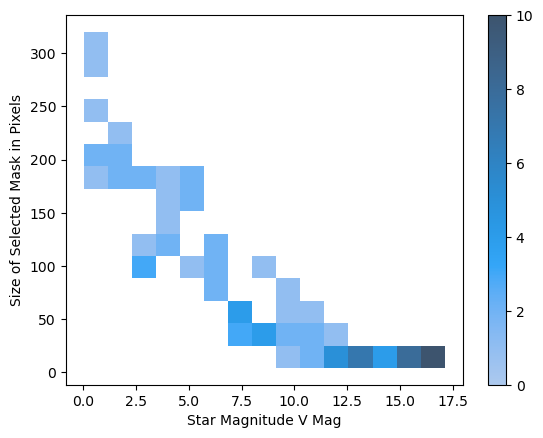

In [39]:
#visualising
plt.figure()
sns.histplot(x=masking_res.Vmag, y=masking_res.mask_radius_px, cbar=True, bins=15)

plt.xlabel("Star Magnitude V Mag")
plt.ylabel("Size of Selected Mask in Pixels")


plt.savefig(filepath+"maskSize_vs_StarMagnitude.pdf")

plt.show()

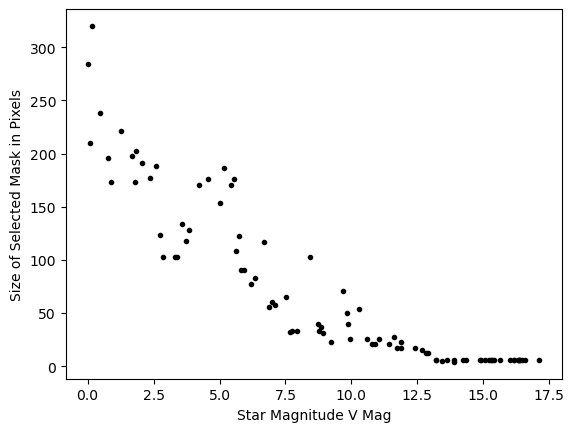

In [40]:
plt.plot(masking_res.Vmag, masking_res.mask_radius_px, "k.")

plt.xlabel("Star Magnitude V Mag")
plt.ylabel("Size of Selected Mask in Pixels")

plt.show()

In [41]:
masking_res["mask_radius_deg"] = masking_res.mask_radius_px / (4*60*60) #converting to degs from pixels (ps1 resolution 4 pixels = 1 arcsec)

In [42]:
masking_res.head()

,ra,dec,mask_radius_px,mask_radius_deg,Vmag
0,19.825927,29.217798,103,0.007153,8.432
1,19.491999,29.492596,23,0.001597,9.222
2,19.717663,29.507802,26,0.001806,9.944
3,19.599073,29.583433,33,0.002292,8.779
4,19.668252,29.822978,31,0.002153,8.906


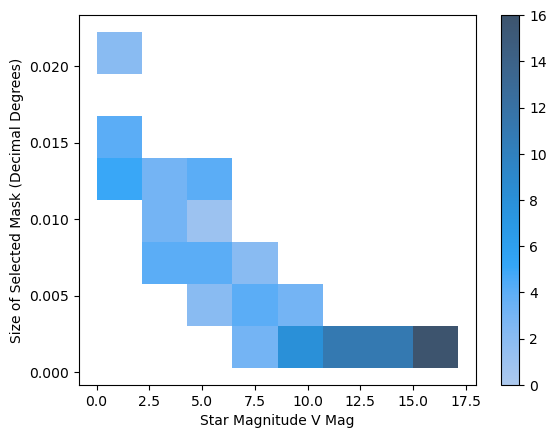

In [43]:
#visualising
plt.figure()
sns.histplot(x=masking_res.Vmag, y=masking_res.mask_radius_deg, cbar=True)

plt.xlabel("Star Magnitude V Mag")
plt.ylabel("Size of Selected Mask (Decimal Degrees)")

plt.show()

In [44]:
from scipy.optimize import curve_fit

def objective_func(x, a, b, c):
    return a*x**2 + b*x + c

xdata = masking_res.Vmag.ravel()
ydata = masking_res.mask_radius_px.ravel()

In [45]:
popt, other = curve_fit(objective_func, xdata, ydata, p0=(1,1,70)) 

In [46]:
other

array([[ 1.41334528e-02, -2.47398772e-01,  7.13350221e-01],
       [-2.47398772e-01,  4.60988935e+00, -1.50134320e+01],
       [ 7.13350221e-01, -1.50134320e+01,  6.61344133e+01]])

In [47]:
print(popt)

a,b,c = popt



[  0.99504614 -30.94434771 245.40805416]


In [48]:
print(a,b,c)

0.995046141953137 -30.944347706107628 245.40805415586837


In [49]:
xvals = np.linspace(0,20,1000)
yvals = objective_func(xvals, a, b, c)

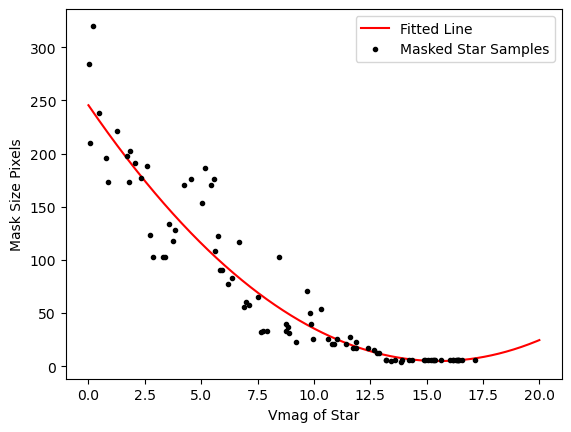

In [50]:
plt.plot(xvals, yvals, "r", label="Fitted Line")
plt.plot(masking_res.Vmag, masking_res.mask_radius_px, "k.", label="Masked Star Samples")
plt.ylabel("Mask Size Pixels")
plt.xlabel("Vmag of Star")
plt.legend()
plt.show()

### Creating the masking Function for stars

In [51]:
def masking_func(vmagnitude):
    
    # if vmagnitude > 17.1 or vmagnitude < 0:
    #     raise ValueError("Function not Defined for Values outside of the range 0 - 17.1")

    a = 0.99504614
    b = -30.94434771
    c = 245.40805417
    
    return a * vmagnitude ** 2 + b * vmagnitude + c

### Seeing how much area of the sky is covered by the star masks

- Query 1 sq degree of sky for the bright stars and apply masks and add up the size of masks

- for area 1 sq degree radius must be 0.56419 deg

In [52]:
search_rad = 0.56419

In [53]:
bright_star_df = af.search_bright_stars(45,45, search_rad)

In [54]:
bright_star_df.Vmag.isna().sum()

167

In [55]:
vmags = bright_star_df.Vmag.dropna().reset_index(drop=True)

In [56]:
radii = masking_func(vmags)

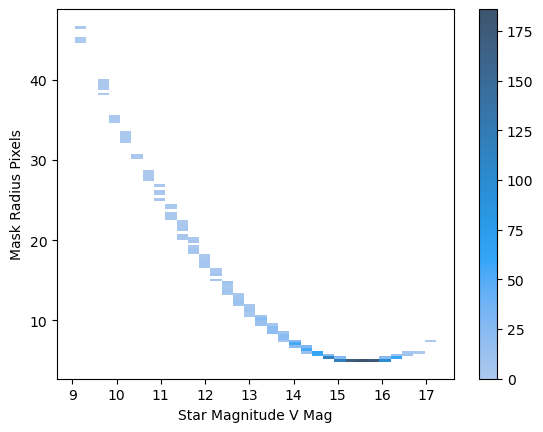

In [57]:
#visualising
sns.histplot(x=vmags, y=radii, cbar=True)

plt.xlabel("Star Magnitude V Mag")
plt.ylabel("Mask Radius Pixels")

plt.show()

In [58]:
radii_deg = radii/4/60/60

In [59]:
def area_circ(radii):
    return np.pi * radii ** 2

In [60]:
mask_area_deg = area_circ(radii_deg)

In [61]:
total_area = 1
total_area_masked_by_stars = mask_area_deg.sum()

In [62]:
percent_masked_by_stars = total_area_masked_by_stars/total_area * 100/1

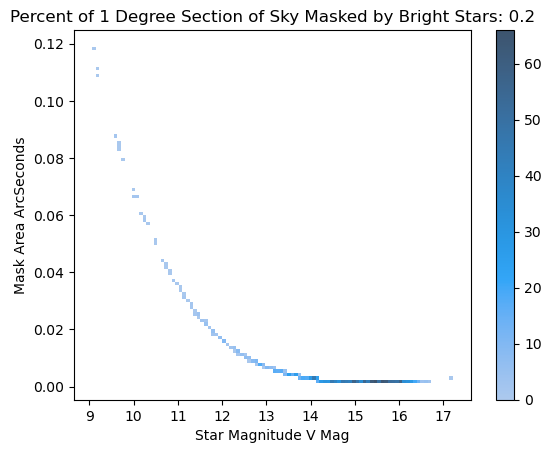

In [65]:
#visualising
sns.histplot(x=vmags, y=mask_area_deg * 60 * 60, cbar=True, bins=100)

plt.xlabel("Star Magnitude V Mag")
plt.ylabel("Mask Area ArcSeconds")

plt.title(f"Percent of 1 Degree Section of Sky Masked by Bright Stars: {round(percent_masked_by_stars, 3)}")

plt.show()